# Imports
## Libraries

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import pybaseball
import sklearn.naive_bayes as nb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.tree
import sklearn.ensemble
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import VotingRegressor

## Data

In [8]:
## data = pybaseball.statcast('2021-04-01', '2021-10-03') # using pybaseball to gather statcast data
## data.to_csv('2021_statcast.csv') # create csv
pd.set_option("display.max_columns", None)
data = pd.read_csv('Data/2021_statcast.csv')
# Nulls on pitch type caused issues, changed to "Undefined"
data['pitch_type'] = data.pitch_type.apply(lambda x : 'Undefined' if pd.isnull(x) else x)
# Added count variable for foltynewicz visaulization in tableau
data['Count'] = data[['balls', 'strikes']].apply(lambda x: f"{str(x.balls)} - {str(x.strikes)}", axis = 1)
folty = data[data['player_name'] == 'Foltynewicz, Mike'].groupby(['Count', 'pitch_type'])[['pitch_type']].count()
# folty.to_csv('Data/folty.csv')

# Read in fangraphs data, rearrange names to match statcast
year_stats = pd.read_csv('Data/fangraphs_2021.csv')
year_stats.Name = year_stats.Name.apply(lambda x : f"{x.replace(' ', ',').split(',')[1]}, {x.replace(' ', ',').split(',')[0]}")

## Creating Unpredictability by Release Point Code

In [11]:
unpredictability_svm = [] # list of player names and their unpredictability scores
# Iterate through each player in year_stats. This filters all pitchers with < 50 innings pitched.
for player in year_stats.Name.unique():
    df = data[data['player_name'] == player][['release_pos_x', 'release_pos_y',
                                              'release_pos_z', 'pitch_type']].dropna() # drop nulls
    # Assign predictors to X
    X = df[['release_pos_x', 'release_pos_y', 'release_pos_z']]
    # Target variable
    y = df.pitch_type

    # SVM generally performs significantly better scaled. Pipe scaled data into SVC.
    svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", SVC(class_weight = 'balanced')),
    ])
    try:
        svm_clf.fit(X,y) # fit to data
        preds = svm_clf.predict(X) # make predictions
        score = f1_score(y, preds, average = 'weighted') # Get F1 score
        unpredictability_svm.append((player, 1 - score)) # Unpredictability by release = 1 - F1
    except:
        # Skip players who have insufficient data
        continue

### Top 10 Unpredictability by Pitch Type

In [12]:
pd.DataFrame(unpredictability_svm, columns = ['Player', 'unpredictability_by_release_point']
            ).sort_values('unpredictability_by_release_point', ascending = False).head(10)

,Player,unpredictability_by_release_point
60,"Stroman, Marcus",0.733032
134,"Gibson, Kyle",0.726567
293,"Kremer, Dean",0.701176
146,"Kluber, Corey",0.685260
30,"Woodruff, Brandon",0.679710
168,"Kaprielian, James",0.671325
272,"Happ, J.A.",0.669961
209,"Dunning, Dane",0.668897
193,"Taillon, Jameson",0.665989
263,"Foltynewicz, Mike",0.658583


## Creating Unpredictability by Count

In [13]:
unpredictability_count = []
# Iterate only through players processed by SVM model above
for player in [i[0] for i in unpredictability_svm]:
    count_df = data[data['player_name'] == player][['pitch_type', 'balls', 'strikes']].dropna() # drop nulls
    snb = nb.MultinomialNB()
    snb.fit(count_df[['balls', 'strikes']], count_df.pitch_type) # Fit to X, y
    preds = snb.predict(count_df[['balls', 'strikes']]) # Create preds
    score = f1_score(count_df.pitch_type, preds, average = 'weighted') # Score
    unpredictability_count.append((player, 1 - score)) # Append player name and F1

### Top 10 Unpredictability by Count

In [14]:
pd.DataFrame(unpredictability_count, columns = ['Player', 'unpredictability_by_count']
            ).sort_values('unpredictability_by_count', ascending = False).head(10)

,Player,unpredictability_by_count
263,"Foltynewicz, Mike",0.866543
227,"Lester, Jon",0.852510
75,"Musgrove, Joe",0.848772
204,"Kelly, Merrill",0.842381
149,"Civale, Aaron",0.833508
64,"Wainwright, Adam",0.830090
179,"Gray, Sonny",0.827764
134,"Gibson, Kyle",0.827321
283,"Harvey, Matt",0.827018
129,"Sandoval, Patrick",0.826425


## Temporary dataframe to show unpredictability

In [15]:
temp_df = pd.DataFrame({'Player': [i[0] for i in unpredictability_svm],
                        'unpredictability_release' : [i[1] for i in unpredictability_svm],
                        'unpredictability_count' : [i[1] for i in unpredictability_count]})
# Multiply the two metrics created to give a (stupid) rudimentary leaderboard thus far
temp_df['product'] = temp_df['unpredictability_release'] * temp_df['unpredictability_count']
temp_df.sort_values('product', ascending = False).head(10).reset_index().drop(columns = ['index'])

,Player,unpredictability_release,unpredictability_count,product
0,"Gibson, Kyle",0.726567,0.827321,0.601104
1,"Foltynewicz, Mike",0.658583,0.866543,0.570690
2,"Kluber, Corey",0.685260,0.776676,0.532225
3,"Alcantara, Sandy",0.646386,0.797239,0.515325
4,"Stroman, Marcus",0.733032,0.702589,0.515020
5,"Thompson, Zach",0.626660,0.817686,0.512411
6,"Woodruff, Brandon",0.679710,0.751302,0.510668
7,"Musgrove, Joe",0.600915,0.848772,0.510039
8,"Civale, Aaron",0.605128,0.833508,0.504380
9,"Harvey, Matt",0.602269,0.827018,0.498087


## Rich Hill Anecdote

<AxesSubplot:xlabel='release_pos_x', ylabel='release_pos_z'>

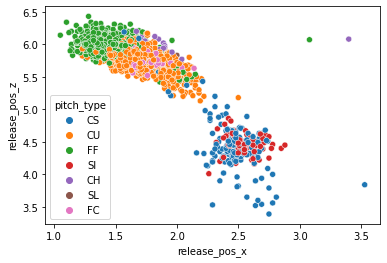

In [16]:
rich_hill = data[data['player_name'] == 'Hill, Rich'][[
    'pitch_type','release_pos_x', 'release_pos_y',
    'release_pos_z', 'estimated_woba_using_speedangle']]
sns.scatterplot(x = 'release_pos_x', y = 'release_pos_z', hue = 'pitch_type', data = rich_hill)

<AxesSubplot:xlabel='release_pos_x', ylabel='release_pos_z'>

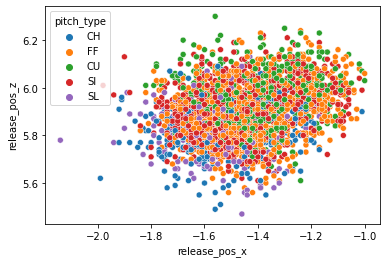

In [17]:
brandon_woodruff = data[data['player_name'] == 'Woodruff, Brandon'][
    ['pitch_type','release_pos_x', 'release_pos_y',
     'release_pos_z', 'estimated_woba_using_speedangle']]
sns.scatterplot(x = 'release_pos_x', y = 'release_pos_z', hue = 'pitch_type', data = brandon_woodruff)

<ipython-input-18-389ac1e5b6b0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  woba_clustering['cluster'] = preds


<AxesSubplot:xlabel='release_pos_x', ylabel='release_pos_z'>

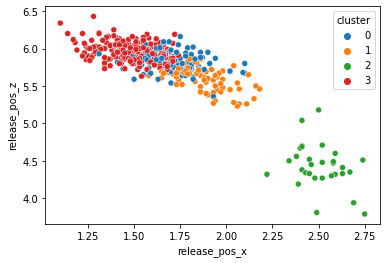

In [18]:
woba_clustering = rich_hill[rich_hill['estimated_woba_using_speedangle'].notnull()]
km = KMeans(n_clusters = 4)
preds = km.fit_predict(woba_clustering[['release_pos_x', 'release_pos_y', 'release_pos_z']])
woba_clustering['cluster'] = preds
sns.scatterplot(x = 'release_pos_x', y = 'release_pos_z', hue = 'cluster', palette = 'tab10', data = woba_clustering)

<AxesSubplot:xlabel='cluster', ylabel='estimated_woba_using_speedangle'>

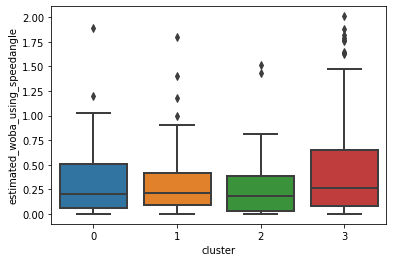

In [19]:
# Rich Hill xwOBA by Cluster
sns.boxplot(x = 'cluster', y = 'estimated_woba_using_speedangle', linewidth=2.0, data = woba_clustering)

## Calculating Standard Deviations for Release, Plate

In [20]:
std_df = data[data['player_name'].isin(year_stats.Name.unique())][
    ['player_name', 'release_speed', 'release_pos_x', 'release_pos_z', 'release_pos_y']]
std_df = std_df.groupby('player_name').std().reset_index()
std_df.columns = ['player_name', 'release_speed_std', 'release_pos_x_std', 'release_pos_z_std', 'release_pos_y_std']

plate_std = []
for i in year_stats.Name.unique():
    aggregated = data[data['player_name'] == i].groupby(['game_date','batter'])[['plate_x', 'plate_z']].std().dropna()
    plate_x_std = np.mean(aggregated.plate_x)
    plate_z_std = np.mean(aggregated.plate_z)
    plate_std.append((i, plate_x_std, plate_z_std))
plate_df = pd.DataFrame(plate_std, columns = ['player_name', 'plate_x_std', 'plate_z_std'])

## Tying it all together

In [21]:
unpredict_df = pd.DataFrame.from_dict({'player_name' : [i[0] for i in unpredictability_svm],
                                       'unpredictability_svm' : [i[1] for i in unpredictability_svm],
                                       'unpredictability_count' : [i[1] for i in unpredictability_count]
                                      })
unpredict_df = unpredict_df.merge(plate_df, on = 'player_name')
unpredict_df = unpredict_df.merge(std_df, on = 'player_name')
unpredict_df = unpredict_df.merge(year_stats[['Name', 'CSW%']], left_on = 'player_name', right_on = 'Name')
unpredict_df['CSW'] = unpredict_df['CSW%'].apply(lambda x: float(x.replace('%', '')))
unpredict_df.drop(columns = ['Name', 'CSW%'], inplace = True)

## First Pass at Training Models

In [22]:
scaler = StandardScaler()
X = scaler.fit_transform(unpredict_df[['unpredictability_svm', 'unpredictability_count', 'plate_x_std','plate_z_std','release_speed_std','release_pos_x_std','release_pos_z_std','release_pos_y_std']])
y = unpredict_df['CSW']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

decision_trees = sklearn.tree.DecisionTreeRegressor()
random_forests = sklearn.ensemble.RandomForestRegressor()
gradient_descent = sklearn.linear_model.SGDRegressor()
lasso = sklearn.linear_model.Lasso()
elastic_net = sklearn.linear_model.ElasticNet()
ridge = sklearn.linear_model.Ridge()
bagging = sklearn.ensemble.BaggingRegressor()
models = [decision_trees, random_forests, gradient_descent, lasso, elastic_net, ridge, bagging]
for model in models:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f'{model} RMSE on test set:')
    print("-------------------")
    print('R-Squared: %.2f' % r2_score(y_test, preds))
    print('RMSE: %.2f' %np.sqrt(mean_squared_error(y_test, preds)))
    print('\n')

DecisionTreeRegressor() RMSE on test set:
-------------------
R-Squared: -0.81
RMSE: 3.38


RandomForestRegressor() RMSE on test set:
-------------------
R-Squared: 0.05
RMSE: 2.45


SGDRegressor() RMSE on test set:
-------------------
R-Squared: 0.06
RMSE: 2.44


Lasso() RMSE on test set:
-------------------
R-Squared: -0.01
RMSE: 2.52


ElasticNet() RMSE on test set:
-------------------
R-Squared: 0.01
RMSE: 2.50


Ridge() RMSE on test set:
-------------------
R-Squared: 0.08
RMSE: 2.41


BaggingRegressor() RMSE on test set:
-------------------
R-Squared: -0.05
RMSE: 2.57




## Tuning models

In [25]:
grid = {lasso : {'alpha' : [i / 100 for i in range(1,20)], # Lasso param grid
                 'max_iter' : [500,1000, 1500, 2000]},
        
        gradient_descent: {'max_iter': [500,1000, 1500, 2000], # Gradient descent param grid
              'penalty' : ['l2', 'l1', 'elasticnet'],
             'learning_rate' : ['constant', 'optimal', 'invscaling', 'adaptive']},
        
        elastic_net:  {'alpha' : [i / 100 for i in range(1,20)], # Elastic net param grid (same as Lasso)
                 'max_iter' : [500,1000, 1500, 2000]} , 
        
        ridge: {'alpha' : [i / 100 for i in range(1,20)],
                'max_iter' : [500,1000, 1500, 2000]} # Ridge param grid
       }

best_models = [lasso, gradient_descent, elastic_net, ridge]
tuned_models = []
coefs = []
for model in best_models:
    
    grid_search = GridSearchCV(model, cv = 5,
                   param_grid = grid[model])
    search = grid_search.fit(X,y)
    print(f"Best Parameters for {model}: {search.best_estimator_}")
    tuned_models.append(search.best_estimator_)
    coefs.append(list(search.best_estimator_.coef_))
    print('\n')

ereg = VotingRegressor(estimators=list(zip(['lasso', 'gradient', 'elastic', 'ridge'], tuned_models)))
ereg = ereg.fit(X, y)
unpredict_df['voting_reg'] = ereg.predict(X)

Best Parameters for Lasso(): Lasso(alpha=0.04, max_iter=500)


Best Parameters for SGDRegressor(): SGDRegressor(max_iter=1500, penalty='elasticnet')


Best Parameters for ElasticNet(): ElasticNet(alpha=0.02, max_iter=500)


Best Parameters for Ridge(): Ridge(alpha=0.19, max_iter=500)




### Results

In [26]:
print(f"R^2 for Voting Regressor: {round(ereg.score(X_test, y_test), 3)}")

R^2 for Voting Regressor: 0.101


#### Top 10 Deceptive Pitchers

In [27]:
unpredict_df.sort_values('voting_reg', ascending = False)[['player_name','voting_reg']].head(10)

,player_name,voting_reg
39,"McGee, Jake",30.572157
16,"Bednar, David",30.569111
111,"Smith, Will",29.964327
2,"Hader, Josh",29.908133
248,"Paddack, Chris",29.874364
115,"Kopech, Michael",29.873272
82,"Kennedy, Ian",29.789402
53,"Staumont, Josh",29.706863
44,"Bender, Anthony",29.706526
25,"Williams, Devin",29.687774


#### Coefficients

In [28]:
pd.DataFrame(pd.DataFrame(coefs, columns = ['unpredictability_svm', 'unpredictability_count', 'plate_x_std','plate_z_std','release_speed_std','release_pos_x_std','release_pos_z_std','release_pos_y_std']).agg('mean'), columns =[ 'Avg. Coefficient'])

,Avg. Coefficient
unpredictability_svm,-0.424560
unpredictability_count,-0.349159
plate_x_std,0.012980
plate_z_std,-0.071504
release_speed_std,0.373965
release_pos_x_std,-0.925144
release_pos_z_std,0.196518
release_pos_y_std,0.654181
